# 분류 Classification

## 3.1 MNIST (Modified National Institute of Standards and Technology database)

http://yann.lecun.com/exdb/mnist/

[NIST의 오리지널 데이터셋](https://www.nist.gov/srd/upload/nistsd19.pdf) 을 기반으로 구성된 숫자 손글씨 데이터베이스

각 숫자 이미지는 $28\times28$ 픽셀의 고정된 크기로 사이즈 정규화(size-normalized) 되어 있으며, Anti-aliasing 이 적용되었고, 영상 중심에 위치하도록 수정되었음.

총 70,000장 = 학습 데이터 60,000장 + 테스트 데이터 10,000장

![Sample of MNIST dataset](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

#### Code) Download MNIST dataset

원본 코드는 문제가 있습니다. ([Chapter 3 - MNIST data not available #7](https://github.com/ageron/handson-ml/issues/7))

In [27]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")
    
mnist

Could not download MNIST data from mldata.org, trying alternative...
Success!


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

### scikit-learn 데이터셋 구조



```
{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}
 ```
 
* `DESCR`: 데이터셋 설명
* `data`: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열 ($X$)
* `target`: 레이블 배열 ($Y$)

In [28]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


* 이미지 갯수 = 70,000장
* feature dimension = 784 차원 = $28 pixel \times 28pixel$ 
* 각 차원의 값의 범위 = `[0, 255]`

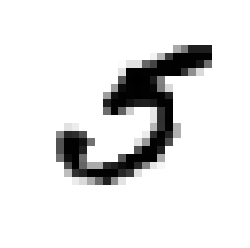

label of 36000 = 5


In [29]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

image_index = 36000

def get_some_digit(index):
    return X[image_index]

some_digit = get_some_digit(image_index)    
some_digit_image = some_digit.reshape(28, 28)
       

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

print('label of {} = {}'.format(image_index, int(y[image_index])))

### 학습용 데이터 준비
MNIST 데이터 셋은 미리 train/test 데이터셋이 구분되어 있음
* train set: 60,000장
* test set: 10,000장

In [0]:
# prepare cross validation
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

하지만 train set 은 label 순으로 정렬되어 있기 때문에,
shuffling 하여 각 fold 에 다양한 label 이 혼합되도록 해야 함

In [31]:
# shuffle to distribute cross validation folds
print('before to shuffle: ', y_train[:24])

import numpy as np

# np.random.seed(0) # set seed number to acquire identical random sequences

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print('after to shuffle: ', y_train[:24])

before to shuffle:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
after to shuffle:  [5. 3. 7. 1. 7. 7. 0. 7. 1. 2. 2. 4. 8. 5. 8. 3. 3. 2. 1. 2. 2. 6. 7. 7.]


## 3.2 Training a binary classifier

### Classification

![algorithm cheat-sheet](http://s5047.pcdn.co/wp-content/uploads/2015/04/drop_shadows_background2.png)

입력 데이터가 label 로 구분되는 경우

MNIST 데이터셋: 0, 1, 2, ... 9 의 label 로 구분됨 => classification 문제

### Binary classification

주어진 샘플을 0/1/2/.../9로 구분하는 것이 아니라, 5인지 아닌지의 **2가지 label ** 로 구분하는 문제

이러한 binary classification 을 10개 가지고 있다면 이를 조합하여 주어진 샘플의 label 을 구할 수 있음



In [32]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print(y_train[:12])
print(y_train_5[:12])

[5. 3. 7. 1. 7. 7. 0. 7. 1. 2. 2. 4.]
[ True False False False False False False False False False False False]


### SGDClassifier 기반 학습

* 확률적 경사 하강법 (Stochastic Gradient Descent)
* **매우 큰 데이터셋** 을 효율적으로 처리하는 장점
* 한번에 하나씩 훈련 샘플을 독립적으로 처리
* **온라인 학습** 에 적합

In [33]:
from sklearn.linear_model import SGDClassifier

# train
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

# test
# sgd_clf.predict(some_digit)

# error on the test - shape problem
print('shape of some_digit: {}'.format(some_digit.shape))
sgd_clf.predict(some_digit.reshape(1, -1))

shape of some_digit: (784,)


array([ True])

In [34]:
# false example
other_index = 50000
some_other_digit = get_some_digit(other_index)
print('label {} = {}'.format(other_index, int(y[other_index])))

sgd_clf.predict(some_other_digit.reshape(1, -1))

label 50000 = 8


array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

folds가 3개인 K-겹 교차 검증(K-fold cross-validation)

In [35]:
# manual cross validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    # train for this fold
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    clone_clf.fit(X_train_folds, y_train_folds)


    # test for this fold
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.94785
0.93865
0.9687


In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94785, 0.93865, 0.9687 ])

dumb classifier 를 이용한 성능 확인

In [37]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90875, 0.90825, 0.91195])

항상 `not_5` 로 판정하더라도 전체 데이터 중에 `5` 샘플은 10% 밖에 없으므로 90%의 정확도 제공

==> **`accuracy`는 적합한 성능 측정 기준이 아님**
(특히, 'skewed datasets' (한 클래스가 다른 클래스에 비해 상당히 많음)에 대해서)


### 3.3.2 Confusion Matrix

Confusion Matrix는 Training 을 통한 Prediction 성능을 측정하기 위해 예측 value와 실제 value를 비교하기 위한 표를 일컫는다

일반적으로 각 **열**은 **예측된 클래스(predicted class)**를 나타내고,
각 **행**은 **실제 클래스(actual class)**를 나타낸다.
(반대도 엄청 많다.)

![confusion matrix](https://t1.daumcdn.net/cfile/tistory/99B785335A0FCF9F23)

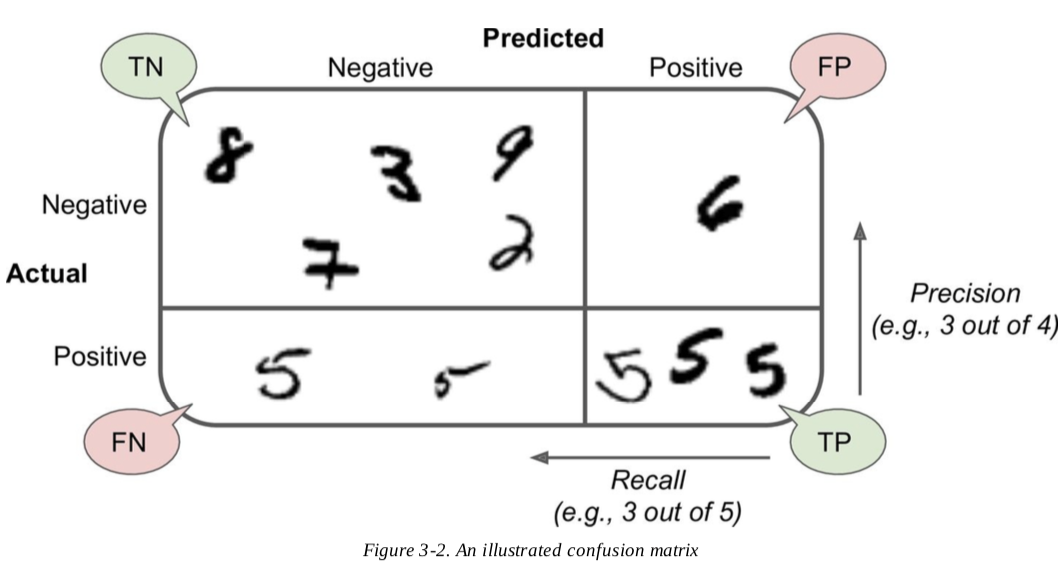

In [38]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

print(len(y_train_pred))

60000


위에서는 `cross_val_score()` 를 사용하고, 여기서는 `cross_val_predict()`를 사용했음.

`cross_val_score()` 는 cross validation 후에 K-folds 들에 대한 evaluation score를 리턴하는 반면,
`cross_val_predict()`는 예측 값을 리턴함
(책에서는 clean prediction이라는 표현을 사용 - 예측이 training 동안 만들어진 model 에 의해서만 이루어지는 경우를 의미)

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53913,   666],
       [ 2230,  3191]])

### 3.3.3 Precision and Recall


#### Precision (정밀도)

the accuracy of the positive predictions

$precision = \frac{TP}{TP+FP}$

#### recall (재현율) / sensitivity / true positive rate(TPR)

$recall = \frac{TP}{TP+FN}$



In [40]:
from sklearn.metrics import precision_score, recall_score

print('precision: {}'.format(precision_score(y_train_5, y_train_pred)))
print('recall: {}'.format(recall_score(y_train_5, y_train_pred)))

precision: 0.827326938034742
recall: 0.5886367828813872


$precision = 0.82$

=> 5로 판별된 이미지 중에서 82%만 정확함

$recall = 0.78$

=> 전체 숫자 5 중에서 78%만 정상 감지

#### $F_1$ score

Precision & recall 의 조화평균

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [41]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.6878637637421858

$F_1$ 점수는 precision 과 recall 이 비슷할 때 높음

문제에 따라 각각 중요한 문제들이 존재

* 어린 아이에게 안전한 동영상을 걸러내는 분류기
    * recall 이 높으나 나쁜 동영상이 몇개 노출되는 것보다
    * 좋은 동영상이 많이 제외되어도 (낮은 recall) 안전한 것들만 노출시키는(높은 precision) 분류기가 좋음
* 감시 카메라로 도둑 잡는 분류기
    * recall 이 매우 높으면 precision 이 조금 낮더라도 괜찮음

### 3.3.4 precision/recall trade-off

decision function: 샘플에서 클래스에 해당되는 확률/점수. threshold 보다 크면 positive, 작으면 negative

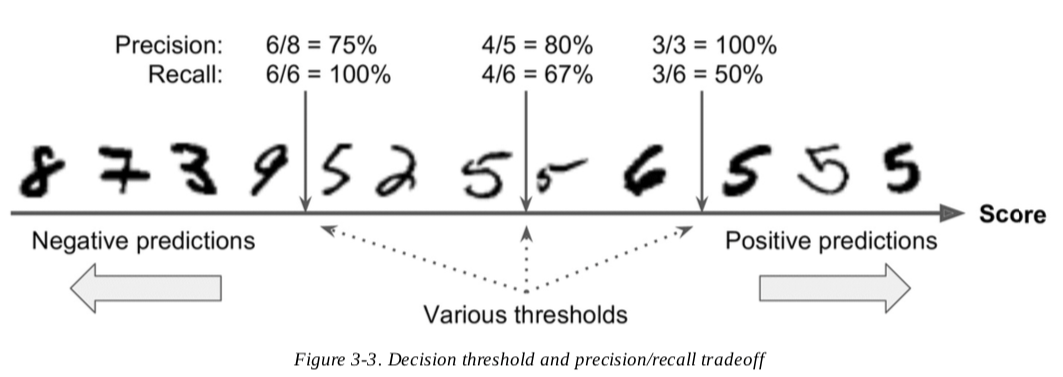


In [42]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[230676.50748496]
[ True]


In [44]:
threshold = 300000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


적당한 threshold 결정

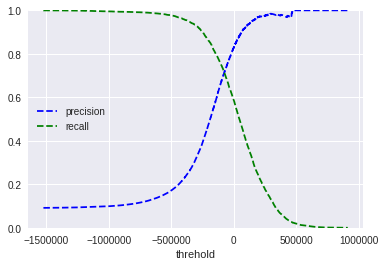

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
    plt.xlabel('threhold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


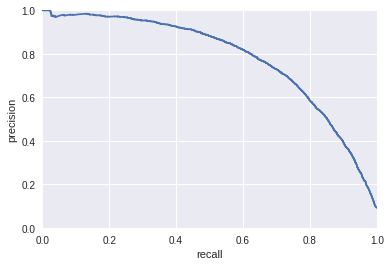

In [53]:
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
plot_precision_recall(precisions, recalls)
plt.show()

precision 90% 분류기

위 그림에서 precision 90% 는 threshold 70,000 임

이 세팅으로 분류하려면, `predict()` 함수 대신 다음 코드 실행

In [54]:
y_train_pred_90 = (y_scores > 70000)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9046401169163317
0.4567422984689172


### 3.3.5 ROC curve

Receiver Operating Characteristic

False Positive Rate 에 대한 True Positive Rate 의 곡선



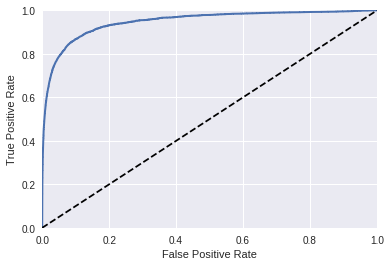

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Area Under Curve(AUC) 를 측정하면 분류기 비교 가능.

* 완벽한 분류기: AUC = 1
* 완전 랜덤 분류기: AUC = 0.5

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9480952418468507

PR curve
* 양성 클래스가 드물거나
* 거짓 음성보다 거짓 양성이 중요할 때

ROC curve
* 음성과 양성 클래스 양이 유사
* 거짓 음성도 중요할 때

상기 ROC 커브를 보면 좋은 분류기로 보이지만,
이는 양성 클래스(5인 샘플)가 매우 적기 때문임.

PR곡선은 분류기의 성능 개선 여지가 얼마나 되는지 (오른쪽 위 모서리에 가까워질 수 있는지) 보여줌

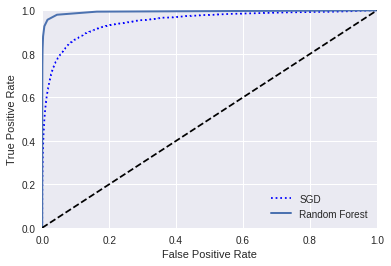

AOC of Random Forest: 0.9936254912200282
Precision of Random Forest: 0.3773281053073799
Recall of Random Forest: 0.9940970300682531


In [63]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print('AOC of Random Forest: {}'.format(roc_auc_score(y_train_5, y_scores_forest)))
y_train_forest = y_scores_forest > 0
print('Precision of Random Forest: {}'.format(precision_score(y_train_5, y_train_forest)))
print('Recall of Random Forest: {}'.format(recall_score(y_train_5, y_train_forest)))

## 3.4 Multiclass Classification

Random Forest, Naive Bayes classifier 는 기본적으로 multi class 처리 가능

SVM, Linear classifier 는 Binary 클래스만 처리 가능

**OvA (One-versus-all, One-versus-the-rest) strategy**: 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템 만들 수 있음

**OvO (One-versus-one) strategy**: 0 vs 1, 0 vs 2, 1 vs 2 분류기 등 숫자 조합마다 이진 분류기 훈련. $N$개 클래스라면 $\frac{N\times(N-1)}{2}$개의 분류기가 필요

훈련 세트 크기에 민감한 분류기(ex. SVM)에서는 큰 훈련세트에서 소수의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련기를 훈련시키는 것이 빠르므로 OvO가 선호될 수 있음



In [64]:
# multi-class classification
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

scikit-learn 이 자동으로 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

In [70]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

print('max index = {}'.format(np.argmax(some_digit_scores)))
print('classes: {}'.format(sgd_clf.classes_))
print('predicted label: {}'.format(sgd_clf.classes_[np.argmax(some_digit_scores)]))

[[-103060.35890567 -504826.86884165 -295749.14103328  -98065.64111565
  -415527.25962638  230676.50748496 -833556.48884036 -132657.65212694
  -767999.30149828 -745760.09600972]]
max index = 5
classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
predicted label: 5.0


OvO 나 OvA 를 강제하려면, `OneVsOneClassifier` 나 `OneVsRestClassifier` 사용

In [73]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
print(len(ovo_clf.estimators_))
print('classes: {}'.format(ovo_clf.estimators_))

45
classes: (SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False), SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False), SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False), SGDClassifier(alpha=0.0001,

RandomForestClassifier 훈련

In [76]:
forest_clf.fit(X_train, y_train)
print('prediction of 5: {}'.format(forest_clf.predict([some_digit])))

print('probability of each classes: {}'.format(forest_clf.predict_proba([some_digit])))



prediction of 5: [5.]
probability of each classes: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


분류기 평가 - Cross Validation 적용


In [80]:
# 대조군: dumb classifier - Never5Classifier
print('Cross Validation - Never5Classifier: {}'.format(cross_val_score(never_5_clf, X_train, y_train, cv=3, scoring='accuracy')))


# 비교군
print('Cross Validation - SGD classifier: {}'.format(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')))


Cross Validation - Never5Classifier: [0.10015 0.09635 0.09965]
Cross Validation - SGD classifier: [0.8760248  0.88109405 0.8713307 ]


87% 정도이므로 나쁘진 않으나 개선의 여지가 있음

개선 방법 - **입력 스케일 조정**

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90911818, 0.91184559, 0.90843627])

## 3.5 Error Analysis

성능 향상 방법 - **에러의 종류 분석**

[[5736    3   18    8   10   52   41    8   42    5]
 [   1 6484   48   27    5   31    6   10  115   15]
 [  59   36 5330  105   77   23   83   58  171   16]
 [  51   43  128 5370    5  210   33   54  138   99]
 [  20   27   46    9 5347    8   54   31   88  212]
 [  72   42   41  201   80 4560  112   30  183  100]
 [  30   26   48    2   39   96 5626    9   41    1]
 [  23   25   66   23   64   10    7 5806   18  223]
 [  53  141   66  156   14  147   53   23 5065  133]
 [  42   34   25   90  178   26    2  206   82 5264]]


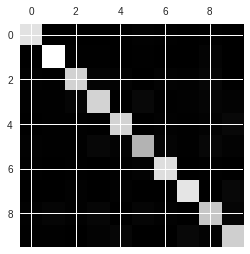

In [83]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

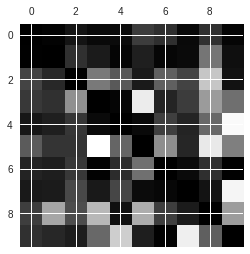

In [86]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

위 그래프에서 밝은 셀들이 에러

특히, 3을 5로 오인식, 5를 3으로 오인식 등의 문제

이 숫자들에 대한 훈련 데이터를 더 모으거나, 분류기에 도움될만한 특성 추가 (ex. 동심원의 수)

In [0]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


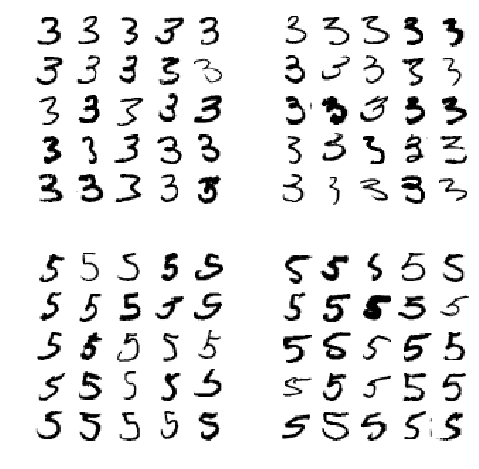

In [92]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


이미지 레벨로 오류 케이스를 분석하여 데이터 보강

이미지 위치를 중앙으로 배치하고, 회전되지 않도록 전처리

## 3.6 다중 레이블 분류

분류기가 샘플마다 여러 개의 클래스를 출력해야 하는 경우

ex. 얼굴 인식 분류기 - 사진에 여러 사람이 등장하는 경우

실습) 입력된 숫자에 대해서 큰 수 여부, 홀수 여부 태깅

In [94]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

다중 레이블 분류기 평가 - $F_1$ 점수

In [108]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


KeyboardInterrupt: ignored

## 3.7 다중 출력 다중 클래스 분류 (multioutput-multiclass classification) / 다중 출력 분류 (multioutput classification)

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화



In [111]:
noise = np.random.randint(0, 255, (len(X_train), 784))
print('noise: ', noise.shape, noise)
X_train_mod = X_train + noise
noise = np.random.randint(0, 255, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

noise:  (60000, 784) [[210  54 103 ... 114 184   3]
 [190 212 146 ...  67  85  65]
 [132  27 125 ...  27 139 108]
 ...
 [183 106  15 ... 139 108 234]
 [ 58 115 204 ...  24 188  58]
 [197 186  38 ... 109 144  84]]


In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

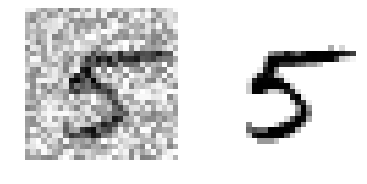

In [112]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

다중 출력 분류기로 이미지를 깨끗하게 만듦

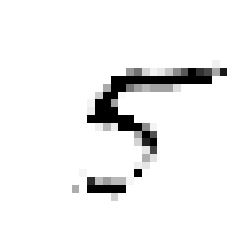

In [113]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)